In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState

In [2]:
def ReadIonosphere(path):
    ionosphere = pd.read_csv(path,header=None, sep=" ") #read file
    return ionosphere.iloc[:,[i for i in range(34)]] , ionosphere[34] #return columns 1-34 as pattern matrix and column 35 as classes vector

In [3]:
file_path = r'C:\Users\krist\Downloads\ece\8ο\Αναγνωριση προτυπων\Ergastiriakes Askisis\PatRec\DATA\ionosphere.data'
X,y = ReadIonosphere(file_path)

In [4]:
def split(X,y):
    b, g = [x for _, x in X.groupby(y == 'b')] #split data into to categories according to labels
    return g.to_numpy(),b.to_numpy() #return them as numpy arrays

In [5]:
def K_virtual_centers(X, K):
    prng = RandomState(1059389) #random state for reproducibility
    featuresNo = X.shape[1]
    centers = prng.rand(K,featuresNo) #initialize centers randomly

    while True:
        old_centers = np.copy(centers) #old centers array, used to test convergence
        virtual_classes = [[] for i in range(K)] #will contain patterns of each virtual class 
        
        for i in X: #for each pattern
            cls = np.argmin(np.sum((centers - i)**2, axis=1)) #find its closest center, euclid square distance
            virtual_classes[cls].append(i) #append to this center's class
        
        for i,cls in enumerate(virtual_classes): #for each virtual class
            if cls!=[]: #if class is not empty
                centers[i] = np.mean(cls, axis=0) #find its new center
            
        if (centers == old_centers).all(): #if new_centers are equal to old, Kmeans has converged
            break
            
    return centers

In [6]:
def K_centers(X, K):
    prng = RandomState(1059389) #random state for reproducibility
    featuresNo = X.shape[1]
    centers = X[prng.randint(X.shape[0], size=K), :] #random patterns as initial centers
    
    while True:
        old_centers =np.copy(centers) #old centers array, used to test convergence
        virtual_classes = [[] for i in range(K)] #will contain patterns of each virtual class
        
        for i in X:
            cls = np.argmin(np.sum((centers - i)**2, axis=1)) #find its closest center, euclid square distance
            virtual_classes[cls].append(i) #append to this center's class
        
        for i,cls in enumerate(virtual_classes):
            mind = np.inf #set initial minimum distance to infinity
            for pattern in cls: #for each pattern in the dataset
                d = np.sum((cls - pattern)**2) #find sum of distances from each pattern in its class
                if d < mind: #if distance sum < current minimum distance
                    centers[i] = pattern #set this pattern as the new class center
                    mind = d #update min distance
        
        if (centers == old_centers).all(): #if new_centers are equal to old, Kmeans has converged
            break

    return centers

In [7]:
def binary_Kmeans(X,y,K, reference = 'virtual_centers'):
    
    #method selection
    if reference == 'virtual_centers':
        method = K_virtual_centers

    elif reference == 'centers':
        method = K_centers

    else :
        raise Exception("choose a reference between 'centers' and 'virtual_centers'")
            
    category1, category2 = split(X,y) #split data into to categories
    centers = []
    
    for i in [category1, category2]: #for each category
        centers.append(method(i,K)) #find centers
        
    return centers

In [8]:
def evaluate(X,y,centers):
    X = X.to_numpy()
    labels = ['b','g'] #data labels
    correct_classifications = 0 
    
    for i, pattern in enumerate(X): #for each pattern
        distances = np.array([np.min(np.sum((center - pattern)**2, axis=1)) for center in centers]) #find min distance from each set of class centers                                                                                                
        
        if y[i] == labels[np.argmin(distances)]: #classify pattern to closest center's category
            correct_classifications+=1 #and if the classification is correct, increase correct classifications
        
    return 1 - correct_classifications/len(X) #error percentage
        

In [12]:
centers = binary_Kmeans(X,y,3,'centers')
pd.DataFrame(centers[1].T, columns = ['center 1','center 2','center 3'])

,center 1,center 2,center 3
0,1.00000,1.00000,1.00000
1,0.00000,0.00000,0.00000
2,0.81143,0.83609,0.86689
3,0.03714,0.13215,0.35950
4,0.85143,0.72171,0.72014
5,-0.00143,0.06059,0.66667
6,0.79000,0.65829,0.37201
7,0.00714,0.08315,0.83049
8,0.79571,0.23888,0.08646
9,-0.04286,0.12961,0.85893


In [35]:
evaluate(X,y,binary_Kmeans(X,y,3,'virtual_centers'))

0.09971509971509973

In [13]:
evaluate(X,y,binary_Kmeans(X,y,3,'centers'))

0.2165242165242165

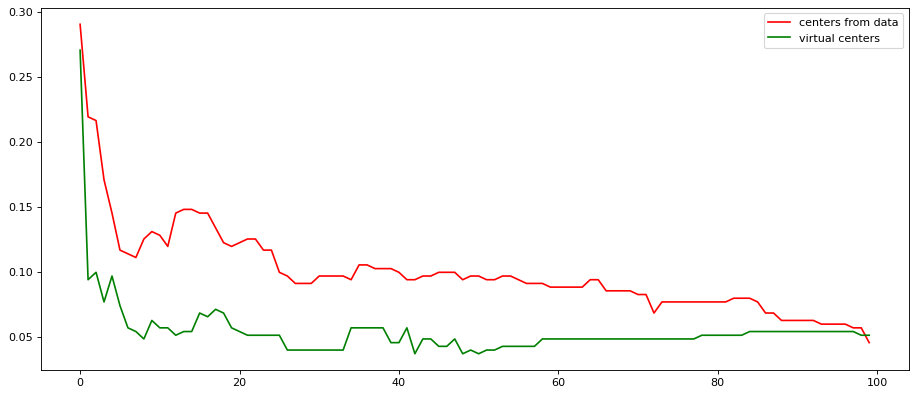

In [11]:
ex_errors = [evaluate(X,y,binary_Kmeans(X,y,i,'centers')) for i in range(1,101)]
virtual_errors = [evaluate(X,y,binary_Kmeans(X,y,i,'virtual_centers')) for i in range(1,101)]

plt.figure(figsize=(14, 6), dpi=80)
plt.plot(ex_errors, color='r', label='centers from data')
plt.plot(virtual_errors, color='g', label='virtual centers')
plt.legend()